In [1]:
import numpy as np
import matplotlib.pyplot as plt
from representations.explicit import Explicit
from sklearn.utils.extmath import randomized_svd
import scipy

%matplotlib inline

In [2]:
explicit = Explicit("pmis/w5/pmi", normalize=True)
PMI = explicit.m.tocsr()

In [3]:
import pandas as pd

counts = pd.read_csv('pmis/w5/counts.words.vocab', 
                     header=None, 
                     names=['word', 'count'], 
                     delimiter=' ', 
                     index_col=0, 
                     squeeze=True, 
                     na_filter=False)

vocab_alphabetic = pd.read_csv('pmis/w5/pmi.words.vocab', 
                               header=None, 
                               names=['word'], 
                               delimiter=' ', 
                               squeeze=True, 
                               na_filter=False)

words_alphabetic = vocab_alphabetic.values
words_by_frequency = counts.index.values

byfreq2alphabetic = np.argsort(words_by_frequency)
permutation = np.argsort(byfreq2alphabetic)

In [4]:
vocab_size = PMI.shape[0]
emb_dim = 500

In [ ]:
P = scipy.sparse.csr_matrix((np.ones(vocab_size), (np.arange(vocab_size), permutation)))

PMI_ = P @ PMI @ P.T

In [42]:
U1, S1, V1T = randomized_svd(PMI, n_components=500)

In [43]:
W1 = U1 @ np.diag(np.sqrt(S1))

In [47]:
!rm embeddings/*
np.savetxt('embeddings/w1.txt', W1, delimiter=' ')
!echo $vocab_size $emb_dim > embeddings/emb1
#!cut pmis/w5/counts.words.vocab -d" " -f1 > pmis/w5/counts.vocab
!paste pmis/w5/pmi.words.vocab embeddings/w1.txt -d " " >> embeddings/emb1

In [45]:
import gensim
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import os

In [48]:
wv_from_text = KeyedVectors.load_word2vec_format(os.path.join("embeddings", "emb1"), binary=False)
ws353 = wv_from_text.evaluate_word_pairs(datapath('wordsim353.tsv'))
google = wv_from_text.evaluate_word_analogies(datapath('questions-words.txt'))
print('WS353 = %.3f' % ws353[0][0])
print('Google = %.3f' % google[0])

WS353 = 0.643
Google = 0.285


In [5]:
cdf = counts.cumsum() / counts.sum()

In [6]:
cdf_abc = cdf.sort_index()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
x_all = torch.tensor(list(zip(PMI.nonzero()[0], PMI.nonzero()[1])), dtype=torch.long)

In [ ]:
y_all = torch.tensor(PMI.data)

In [ ]:
cdf_torch = torch.tensor(cdf_abc.values)

### Optimization

In [ ]:
class Data(Dataset):
    
    def __init__(self):
        self.x = x_all
        self.y = y_all
        self.len = self.x.shape[0]
        
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len

In [ ]:
dataset = Data()

In [ ]:
bs = 500000
trainloader = DataLoader(dataset = dataset, batch_size = bs)

In [ ]:
rho = torch.tensor(0.5, requires_grad = True)

In [ ]:
def forward(x):
    a = torch.sqrt(torch.tensor(2.0)) * torch.clamp(torch.erfinv(2 * cdf_torch[x[:, 0]] - 1), -3, 3)
    b = torch.sqrt(torch.tensor(2.0)) * torch.clamp(torch.erfinv(2 * cdf_torch[x[:, 1]] - 1), -3, 3)
    output = -0.5 * torch.log(1 - rho * rho) - ((a * a + b * b) * rho * rho - 2 * a * b * rho) / (2 * (1 - rho * rho))
    return output

In [ ]:
def criterion(yhat, y):
    #return torch.mean((yhat - y) ** 2)
    return torch.mean(-y * torch.log(yhat))

In [ ]:
optimizer = torch.optim.Adam([rho], lr=0.2)

In [ ]:
epochs = 100
losses = []

for epoch in range(epochs):
    losses[:] = []
    for x, y in trainloader:
        optimizer.zero_grad()
        yhat = forward(x)
        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()
        print(loss.data, rho)
        losses.append(loss.data)
    print("Epoch loss:", np.mean(losses))

### Copula -> Word Vectors

In [ ]:
import gensim
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import os

In [7]:
w1 = PMI.nonzero()[0]
w2 = PMI.nonzero()[1]

In [8]:
my_cdf = cdf_abc.values

In [10]:
a = np.sqrt(2.0) * np.clip(scipy.special.erfinv(2 * my_cdf[w1] - 1), -3, 3)
b = np.sqrt(2.0) * np.clip(scipy.special.erfinv(2 * my_cdf[w2] - 1), -3, 3)

In [41]:
rhos = []
sims = []
anals = []

for i in range(-9, 10):
    r = i / 10.0
    output = -0.5 * np.log(1 - r * r) - ((a * a + b * b) * r * r - 2 * a * b * r) / (2 * (1 - r * r))
    PMI_Copula = scipy.sparse.csr_matrix((output, (w1, w2)))
    U1, S1, V1T = randomized_svd(PMI_Copula, n_components=500)
    W1 = U1 @ np.diag(np.sqrt(S1))
    
    !rm embeddings/*
    np.savetxt('embeddings/w1.txt', W1, delimiter=' ')
    !echo $vocab_size $emb_dim > embeddings/emb1
    !paste pmis/w5/pmi.words.vocab embeddings/w1.txt -d " " >> embeddings/emb1
    
    wv_from_text = KeyedVectors.load_word2vec_format(os.path.join("embeddings", "emb1"), binary=False)
    ws353 = wv_from_text.evaluate_word_pairs(datapath('wordsim353.tsv'))
    google = wv_from_text.evaluate_word_analogies(datapath('questions-words.txt'))
    print('rho = %.2f: WS353 = %.3f, Google = %.3f' % (r, ws353[0][0], google[0]))
    
    rhos.append(r)
    sims.append(ws353[0][0])
    anals.append(google[0])

rho = -0.90: WS353 = 0.176, Google = 0.005
rho = -0.80: WS353 = 0.145, Google = 0.004
rho = -0.70: WS353 = 0.125, Google = 0.005
rho = -0.60: WS353 = 0.107, Google = 0.004
rho = -0.50: WS353 = 0.094, Google = 0.004
rho = -0.40: WS353 = 0.083, Google = 0.004
rho = -0.30: WS353 = 0.066, Google = 0.005
rho = -0.20: WS353 = 0.047, Google = 0.006
rho = -0.10: WS353 = 0.042, Google = 0.008
rho = 0.00: WS353 = nan, Google = 0.000
rho = 0.10: WS353 = 0.134, Google = 0.021
rho = 0.20: WS353 = 0.157, Google = 0.023
rho = 0.30: WS353 = 0.179, Google = 0.023
rho = 0.40: WS353 = 0.208, Google = 0.023
rho = 0.50: WS353 = 0.227, Google = 0.019
rho = 0.60: WS353 = 0.252, Google = 0.017
rho = 0.70: WS353 = 0.275, Google = 0.014
rho = 0.80: WS353 = 0.290, Google = 0.013
rho = 0.90: WS353 = 0.311, Google = 0.014


In [52]:
results = pd.DataFrame({'WS353': sims, 'Google': anals}, index=rhos)

Text(0.5, 0, 'rho')

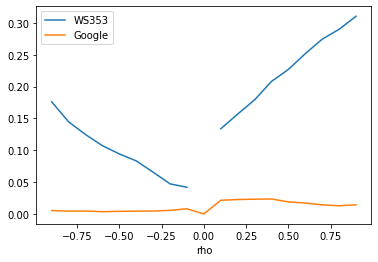

In [59]:
ax = results.plot()
ax.set_xlabel('rho')